In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install resampy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import numpy as np
import pandas as pd
import librosa
import resampy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from scipy.io import wavfile

In [22]:
labels_df = pd.read_csv('/content/drive/My Drive/CS 4641/preprocessed data/df_full.csv')
labels_df = labels_df[['File Name', 'Diagnosis']]

def preprocess_audio(filename, target_length=22050):  # target_length in samples
    # Load the audio file
    audio, sample_rate = librosa.load(filename, sr=None)  # Load at original sr

    # Pad or truncate the audio signal
    if len(audio) > target_length:
        audio = audio[:target_length]  # Truncate
    else:
        audio = librosa.util.fix_length(audio, target_length)  # Pad

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)

    # Compute the mel-scaled spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128, fmax=8000)
    spectrogram = librosa.power_to_db(spectrogram)

    # Average the MFCCs and spectrogram across time frames
    mfccs_processed = np.mean(mfccs.T, axis=0)
    spectrogram_processed = np.mean(spectrogram.T, axis=0)

    return mfccs_processed, spectrogram_processed


In [23]:
mfccs_features, spectrogram_features, labels = [], [], []

for index, row in labels_df.iterrows():
    file_path = '/content/drive/MyDrive/CS 4641/Dataset Files/Respiratory_Sound_Database/audio_and_txt_files/audio/' + str(row['File Name'])
    mfccs, spectrogram = preprocess_audio(file_path)
    mfccs_features.append(mfccs)
    spectrogram_features.append(spectrogram)
    labels.append(row['Diagnosis'])

mfccs_features = np.array(mfccs_features)
spectrogram_features = np.array(spectrogram_features)
labels = np.array(labels)

le = LabelEncoder()
encoded_labels = to_categorical(le.fit_transform(labels))

mfccs_train, mfccs_test, spectrogram_train, spectrogram_test, y_train, y_test = train_test_split(
    mfccs_features, spectrogram_features, encoded_labels, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [24]:
input_mfcc = Input(shape=(mfccs_train.shape[1],))
mfcc_branch = Dense(256, activation='relu')(input_mfcc)
mfcc_branch = BatchNormalization()(mfcc_branch)
mfcc_branch = Dropout(0.5)(mfcc_branch)
mfcc_branch = Dense(128, activation='relu')(mfcc_branch)
mfcc_branch = BatchNormalization()(mfcc_branch)

input_spectrogram = Input(shape=(spectrogram_train.shape[1],))
spectrogram_branch = Dense(256, activation='relu')(input_spectrogram)
spectrogram_branch = BatchNormalization()(spectrogram_branch)
spectrogram_branch = Dropout(0.5)(spectrogram_branch)
spectrogram_branch = Dense(128, activation='relu')(spectrogram_branch)
spectrogram_branch = BatchNormalization()(spectrogram_branch)

concatenated_branches = Concatenate()([mfcc_branch, spectrogram_branch])
concatenated_branches = Dense(256, activation='relu')(concatenated_branches)
concatenated_branches = BatchNormalization()(concatenated_branches)
concatenated_branches = Dropout(0.5)(concatenated_branches)
output = Dense(encoded_labels.shape[1], activation='softmax')(concatenated_branches)

model = Model(inputs=[input_mfcc, input_spectrogram], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 dense_6 (Dense)             (None, 256)                  10496     ['input_3[0][0]']             
                                                                                                  
 dense_8 (Dense)             (None, 256)                  33024     ['input_4[0][0]']             
                                                                                            

Epoch 1/50
23/23 [==============================] - 3s 23ms/step - loss: 2.8677 - accuracy: 0.3315 - val_loss: 23.3035 - val_accuracy: 0.0324
Epoch 2/50
23/23 [==============================] - 0s 10ms/step - loss: 2.1537 - accuracy: 0.4742 - val_loss: 17.0152 - val_accuracy: 0.0108
Epoch 3/50
23/23 [==============================] - 0s 10ms/step - loss: 1.7623 - accuracy: 0.5516 - val_loss: 11.7504 - val_accuracy: 0.0324
Epoch 4/50
23/23 [==============================] - 0s 9ms/step - loss: 1.5697 - accuracy: 0.6033 - val_loss: 6.6406 - val_accuracy: 0.0703
Epoch 5/50
23/23 [==============================] - 0s 10ms/step - loss: 1.2213 - accuracy: 0.6780 - val_loss: 3.9136 - val_accuracy: 0.2432
Epoch 6/50
23/23 [==============================] - 0s 10ms/step - loss: 1.0808 - accuracy: 0.7473 - val_loss: 0.9250 - val_accuracy: 0.7405
Epoch 7/50
23/23 [==============================] - 0s 9ms/step - loss: 0.8871 - accuracy: 0.7948 - val_loss: 0.7638 - val_accuracy: 0.7568
Epoch 8/50
2

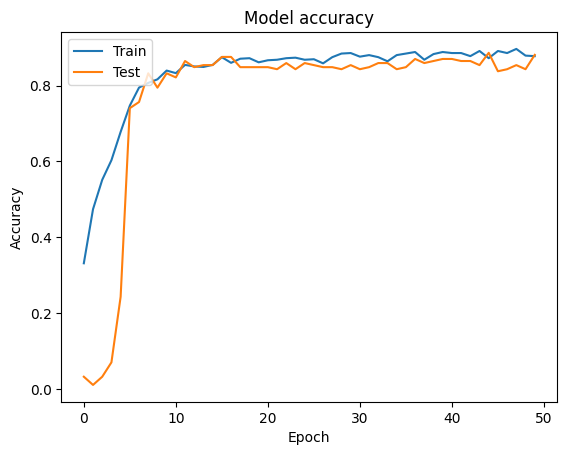

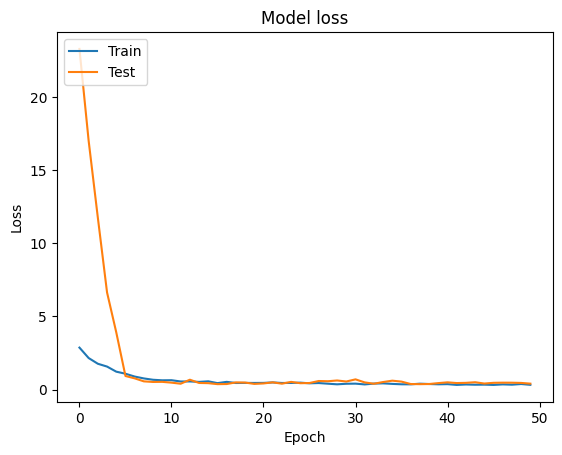

In [25]:
history = model.fit(
    [mfccs_train, spectrogram_train], y_train,
    epochs=50,
    batch_size=32,
    validation_data=([mfccs_test, spectrogram_test], y_test)
)

import matplotlib.pyplot as plt

y_pred = model.predict([mfccs_test, spectrogram_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')
print(f"F1 Macro Score: {f1_macro}")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()